## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [340]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [56]:
!pip install --upgrade gensim

  Using cached gensim-4.2.0-cp39-cp39-win_amd64.whl (23.9 MB)
  Using cached Cython-0.29.28-py2.py3-none-any.whl (983 kB)
  Using cached smart_open-6.0.0-py3-none-any.whl (58 kB)
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.24
    Uninstalling Cython-0.29.24:
      Successfully uninstalled Cython-0.29.24


In [341]:
df = pd.read_csv("train.csv")
df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

### Exploration

In [342]:
data = df[['question1','question2','is_duplicate']]

In [343]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   question1     404289 non-null  object
 1   question2     404288 non-null  object
 2   is_duplicate  404290 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 9.3+ MB


In [344]:
data[data.isna().any(axis=1)]

,question1,question2,is_duplicate
105780,How can I develop android app?,NaN,0
201841,How can I create an Android app?,NaN,0
363362,NaN,My Chinese name is Haichao Yu. What English na...,0


In [345]:
data = data.dropna()

Percentage of question pairs that are similar (is_duplicate = 0): 0.630799407351708
Percentage of question pairs that are unique (is_duplicate = 1): 0.3692005926482919


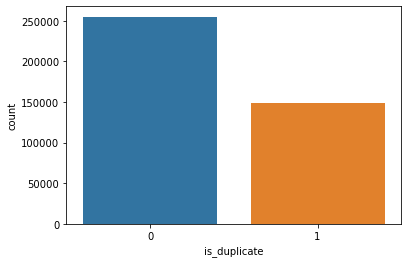

In [346]:
#visualisation of unique questions

sns.countplot(x = data['is_duplicate'])

print("Percentage of question pairs that are similar (is_duplicate = 0):", len(data[data['is_duplicate'] == 0])/len(data))
print("Percentage of question pairs that are unique (is_duplicate = 1):", len(data[data['is_duplicate'] == 1])/len(data))

In [347]:
qids = []
qids.append(df['qid1'].tolist())
qids.append(df['qid2'].tolist())
qids  = [val for sublist in qids for val in sublist]
qids = pd.Series(qids)
qids.value_counts()

2559      157
30782     120
4044      111
2561       88
14376      79
         ... 
416446      1
416444      1
416441      1
416439      1
537933      1
Length: 537933, dtype: int64

Maximum number of times a single question occurs is 157


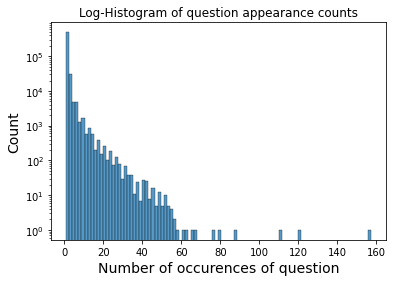

In [348]:
fig, ax = plt.subplots()

sns.histplot(qids.value_counts(),ax=ax, bins=100)
plt.title('Log-Histogram of question appearance counts')
ax.set_xlabel("Number of occurences of question", size=14)
ax.set_ylabel("Count", size=14)
plt.yscale('log')

print ('Maximum number of times a single question occurs is', max(qids.value_counts()))

### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [349]:
from gensim.utils import simple_preprocess #used to tokenize the data
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import nltk
import re

lemmatize = WordNetLemmatizer()
st = nltk.PorterStemmer()

In [350]:
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
import string

    
def cleaning_stopwords(x):
    return " ".join([word for word in str(x).split() if word not in stop_words])



#removing punctuations
english_punctuations = string.punctuation

def remove_punctuation(x):
    text = "".join([char for char in x if char not in string.punctuation])
    return text


def lowercase(x):
    x = x.lower()
    return x


#Applying Lemmetization
lemmatize = WordNetLemmatizer()
def lemmatizer(x):
    lemmatized = [lemmatize.lemmatize(i) for i in x.split(" ")]
    return lemmatized


#Applying Stemming
st = nltk.PorterStemmer()
def stemming_on_text(x):
    text = [st.stem(word) for word in x]
    return text


def preprocessing_text(txt):
    
    if isinstance(txt, float):
        print (txt)
    txt = txt.replace(',000,000', 'm').replace(',000', 'k'
                ).replace("can't", 'cannot').replace("don't",
                'do not').replace("isn't", 'is not').replace("you're",
                'you are').replace("you've", 'you have'
                                   ).replace("you'll", 'you will'
                ).replace("that'll", 'that will').replace("should've",
                'should have').replace("aren't", 'are not'
                ).replace("couldn't", 'could not').replace("didn't",
                'did not').replace("doesn't", 'does not'
                                   ).replace("hadn't", 'had not'
                ).replace("hasn't", 'has not').replace("haven't",
                'have not').replace("mustn't", 'must not'
                                    ).replace("wasn't", 'was not'
                ).replace("i'm", 'i am').replace("he's", 'he is'
                ).replace("she's", 'she is').replace("ain't", 'am not'
                ).replace('%', ' percent '
                ).replace("'ll", ' will').replace("'ve", ' have'
                ).replace("it's", 'it is').replace('\\xe2\\x80\\x99', "'")
# .replace('\\xc3\\xa9', 'e').replace('\\xe2\\x80\\x90', '-').
# replace('\\xe2\\x80\\x91', '-').
# replace('\\xe2\\x80\\x92', '-').
# replace('\\xe2\\x80\\x93', '-').
# replace('\\xe2\\x80\\x94', '-').
# replace('\\xe2\\x80\\x94', '-').
# replace('\\xe2\\x80\\x98', "'").
# replace('\\xe2\\x80\\x9b', "'").
# replace('\\xe2\\x80\\x9c', '"').
# replace('\\xe2\\x80\\x9c', '"').
# replace('\\xe2\\x80\\x9d', '"').
# replace('\\xe2\\x80\\x9e', '"').
# replace('\\xe2\\x80\\x9f', '"').
# replace('\\xe2\\x80\\xa6', '...').#
# replace('\\xe2\\x80\\xb2', "'").
# replace('\\xe2\\x80\\xb3', "'").
# replace('\\xe2\\x80\\xb4', "'").
# replace('\\xe2\\x80\\xb5', "'").
# replace('\\xe2\\x80\\xb6', "'").
# replace('\\xe2\\x80\\xb7', "'").
# replace('\\xe2\\x81\\xba', "+").
# replace('\\xe2\\x81\\xbb', "-").
# replace('\\xe2\\x81\\xbc', "=").
# replace('\\xe2\\x81\\xbd', "(").
# replace('\\xe2\\x81\\xbe', ")")
    txt = re.sub(r"[^A-Za-z0-9(),!.?\'\`]", ' ', txt)
# txt = re.sub(r"\'s", " 's ", txt)
# txt = re.sub(r"\'ve", " 've ", txt)
# txt = re.sub(r"n\'t", " 't ", txt)
# txt = re.sub(r"\'re", " 're ", txt)
# txt = re.sub(r"\'d", " 'd ", txt)
# txt = re.sub(r"\'ll", " 'll ", txt)
# txt = re.sub(r",", ' ', txt)
# txt = re.sub(r"\.", ' ', txt)
# txt = re.sub(r"!", ' ', txt)
# txt = re.sub(r"\(", ' ( ', txt)
# txt = re.sub(r"\)", ' ) ', txt)
# txt = re.sub(r"\?", ' ', txt)
# txt = re.sub(r"\s{2,}", ' ', txt)
      
    txt = remove_punctuation(txt)
    txt = cleaning_stopwords(txt)
    txt = lowercase(txt)
    txt = lemmatizer(txt)
    txt = stemming_on_text(txt)
    return txt


In [351]:
data['question1tokens'] = data['question1'].apply(preprocessing_text)
data['question2tokens'] = data['question2'].apply(preprocessing_text)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



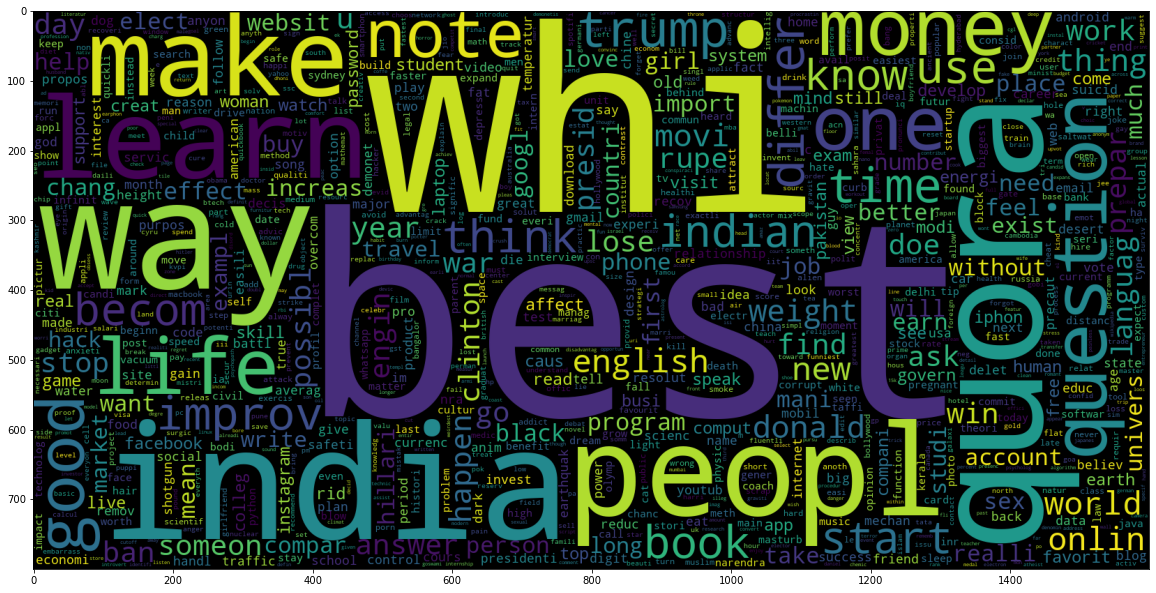

In [352]:
#wordcloud of duplicate questions
import matplotlib.pyplot as plt
from wordcloud import WordCloud

duplicates = [i for i in data[data['is_duplicate']== 1]['question1tokens'].values]
duplicates_forwc  = [val for sublist in duplicates for val in sublist]
print (duplicates)

wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(duplicates_forwc))
plt.figure(figsize = (20,20))
plt.imshow(wc)

### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# # train test split
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(data[['question1','question2','question1tokens','question2tokens']], data.is_duplicate, 
#                                                     test_size=0.20, random_state=42)


In [353]:
from sklearn.feature_extraction.text import TfidfVectorizer
from unicodedata import normalize

def cosine_sim(text1, text2):
    vectorizer = TfidfVectorizer()
    train_set=text1+text2
    train_set=[tmp.lower() for tmp in train_set]
    tfidf = vectorizer.fit_transform(train_set)
    return ((tfidf * tfidf.T).A)[0,1]

In [354]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

def to_word_string(tokens):
    texts = []
    for doc in tokens:
        texts.append(' '.join([word for word in doc]))
    return texts

def vectorizer(X):
    tokens = pd.concat([X['question1tokens'], X['question2tokens']])
    qs = to_word_string(tokens)
   
    vectorizer = CountVectorizer(min_df=0, lowercase=False, max_features=3000)
    vectorizer.fit(qs)
    
    x_q1 = vectorizer.transform(X.question1tokens.astype(str))
    x_q2 = vectorizer.transform(X.question2tokens.astype(str))
    
    train_texts1 = X.question1tokens.values.tolist()
    train_texts2 = X.question2tokens.values.tolist()
    
    X_targets = []
    for text1, text2 in zip(train_texts1, train_texts2):
        X_targets.append(cosine_sim([''.join(ele) for ele in text1], [''.join(ele) for ele in text2]))
    
    X_tfidf = np.hstack((x_q1, x_q2, 
                      scipy.sparse.csc_matrix(np.array(X_targets).reshape(-1, 1))))
    return X_tfidf

def vectorizer2(X):
    tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
    tokens = pd.concat([X['question1tokens'], X['question2tokens']])
    qs = to_word_string(tokens)
    tfidf_vect.fit(qs)
    trainq1_trans = tfidf_vect.transform(X.question1tokens.astype(str))
    trainq2_trans = tfidf_vect.transform(X.question2tokens.astype(str))
    X_tfidf = scipy.sparse.hstack((trainq1_trans,trainq2_trans))
    return X_tfidf

In [290]:
# X_tfidf = vectorizer(X_train)

KeyboardInterrupt: 

In [ ]:
# X_tfidf_test = vectorizer(X_test)

In [ ]:
# X_tfidf

In [ ]:
# X_tfidf_test

### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

In [355]:
df_model= data[['question1tokens','question2tokens']].copy()
y = data.is_duplicate

In [356]:
df_model.question1tokens.astype('str')

0         ['what', 'step', 'step', 'guid', 'invest', 'sh...
1         ['what', 'stori', 'kohinoor', 'koh', 'noor', '...
2         ['how', 'i', 'increas', 'speed', 'internet', '...
3         ['whi', 'i', 'mental', 'lone', 'how', 'i', 'so...
4         ['which', 'one', 'dissolv', 'water', 'quikli',...
                                ...                        
404285    ['how', 'mani', 'keyword', 'racket', 'program'...
404286                    ['do', 'believ', 'life', 'death']
404287                              ['what', 'one', 'coin']
404288    ['what', 'approx', 'annual', 'cost', 'live', '...
404289                    ['what', 'like', 'sex', 'cousin']
Name: question1tokens, Length: 404287, dtype: object

In [398]:
X_tfidf = vectorizer2(df_model)
y = data['is_duplicate'].values

# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, 
                                                    test_size=0.20, random_state=42)


### XGB Classifier

In [400]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix,classification_report


In [406]:
xgb_model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8)
xgb_model.fit(X_train, y_train) 
xgb_prediction = xgb_model.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, xgb_prediction))
print('Recall: ', recall_score(y_test, xgb_prediction))
print('Precision: ', precision_score(y_test, xgb_prediction))
print('F1 Score: ', f1_score(y_test, xgb_prediction))
print('Confusion Matrix : ') 
print(confusion_matrix(y_test, xgb_prediction))
print(classification_report(y_test, xgb_prediction))

[13:55:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy:  0.7818521358430829
Recall:  0.5690868865647627
Precision:  0.7801571618951335
F1 Score:  0.6581125346461729
Confusion Matrix : 
[[46242  4784]
 [12855 16977]]
              precision    recall  f1-score   support

           0       0.78      0.91      0.84     51026
           1       0.78      0.57      0.66     29832

    accuracy                           0.78     80858
   macro avg       0.78      0.74      0.75     80858
weighted avg       0.78      0.78      0.77     80858



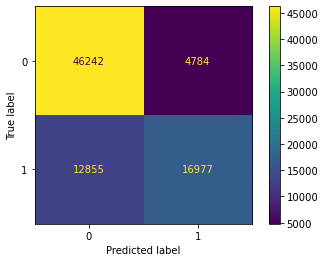

In [407]:
import seaborn as sns
import matplotlib.pyplot as plt    
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(y_test, xgb_prediction, labels=xgb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=xgb_model.classes_)
disp.plot()

plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

colsample_bytree = [0.1, 0.3, 0.5, 1.0]
gamma = [0.1, 1, 1.5]
learning_rate = [0.001, 0.01]
min_child_weight = [1, 5, 10]
scale_pos_weight = [1, 2, 4]
subsample = [0.8, 0.9, 1.0]
n_estimators = [50, 100, 150]
max_depth = [5, 10, 30, 50]

param_grid = dict(
    colsample_bytree=colsample_bytree,
    gamma=gamma,
    learning_rate=learning_rate,
    min_child_weight=min_child_weight,
    scale_pos_weight=scale_pos_weight,
    subsample=subsample,
    n_estimators=n_estimators,
    max_depth=max_depth,
)


model = xgb.XGBClassifier(random_state=1, verbosity=1)

grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           )

best_model = grid_search.fit(X_train, y_train)

xgb_prediction = best_model.predict(X_test)

print('Optimum parameters', best_model.best_params_)
print('word level tf-idf training accuracy score:', accuracy_score(y_train, best_model.predict(X_train)))
print('word level tf-idf validation accuracy score:', accuracy_score(y_test, best_model.predict(X_test)))
print(classification_report(y_test, xgb_prediction))
print(confusion_matrix(y_test, xgb_prediction))

### Logistic Regression

Accuracy:  0.7383932325805733
Recall:  0.5236993832126575
Precision:  0.6922940576948642
F1 Score:  0.5963090898681273
Confusion Matrix : 
[[44082  6944]
 [14209 15623]]


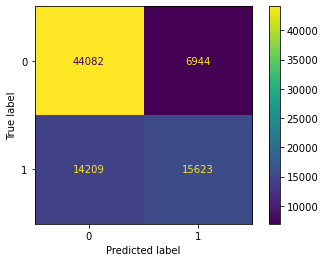

In [408]:
model = LogisticRegression(max_iter=1700)
model.fit(X_train, y_train)


from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

y_pred = model.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('Confusion Matrix : ') 
print(confusion_matrix(y_test, y_pred))

import seaborn as sns
import matplotlib.pyplot as plt    
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)
disp.plot()

plt.show()

### LSTM

In [394]:
from sklearn.feature_extraction.text import TfidfVectorizer
# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['question1tokens','question2tokens']], data.is_duplicate, 
                                                    test_size=0.20, random_state=42)


In [395]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_test = tokenizer.texts_to_sequences(X_test)
X_train = tokenizer.texts_to_sequences(X_train)

In [390]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [391]:
y_train = pad_sequences(y_train, padding='post', maxlen=maxlen)
y_test = pad_sequences(y_test, padding='post', maxlen=maxlen)

ValueError: `sequences` must be a list of iterables. Found non-iterable: 0

In [396]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 50


model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 50)           150       
                                                                 
 flatten_4 (Flatten)         (None, 5000)              0         
                                                                 
 dense_8 (Dense)             (None, 10)                50010     
                                                                 
 dense_9 (Dense)             (None, 1)                 11        
                                                                 
Total params: 50,171
Trainable params: 50,171
Non-trainable params: 0
_________________________________________________________________


In [397]:
history = model.fit(X_train, y_train,
                    epochs=3,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {'(<class \'list\'> containing values of types {"<class \'int\'>"})'}), <class 'pandas.core.series.Series'>